<a href="https://colab.research.google.com/github/gargarchit/PATE_Analysis/blob/master/Classification_of_MNIST_Digits_using_Differential_Privacy_and_performing_PATE_analysis_on_that_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>1. Loading MNIST Data</h2> 

In [0]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])]) #Grey Scale Image
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  #private data
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  #public data

In [2]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [0]:
from torch.utils.data import Subset
num_teachers = 100

teacher_loaders = []  #list of dataloaders

data_size = 600 # mnist_trainset/num_teachers

for i in range(num_teachers):
    
    indices = list(range(i*data_size, (i+1) *data_size))
   
    subset_data = Subset(mnist_trainset, indices)
    
    loader = torch.utils.data.DataLoader(subset_data, batch_size=64, num_workers=2)
    teacher_loaders.append(loader)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

<h2>2. Visualize a Batch of Training Data</h2>

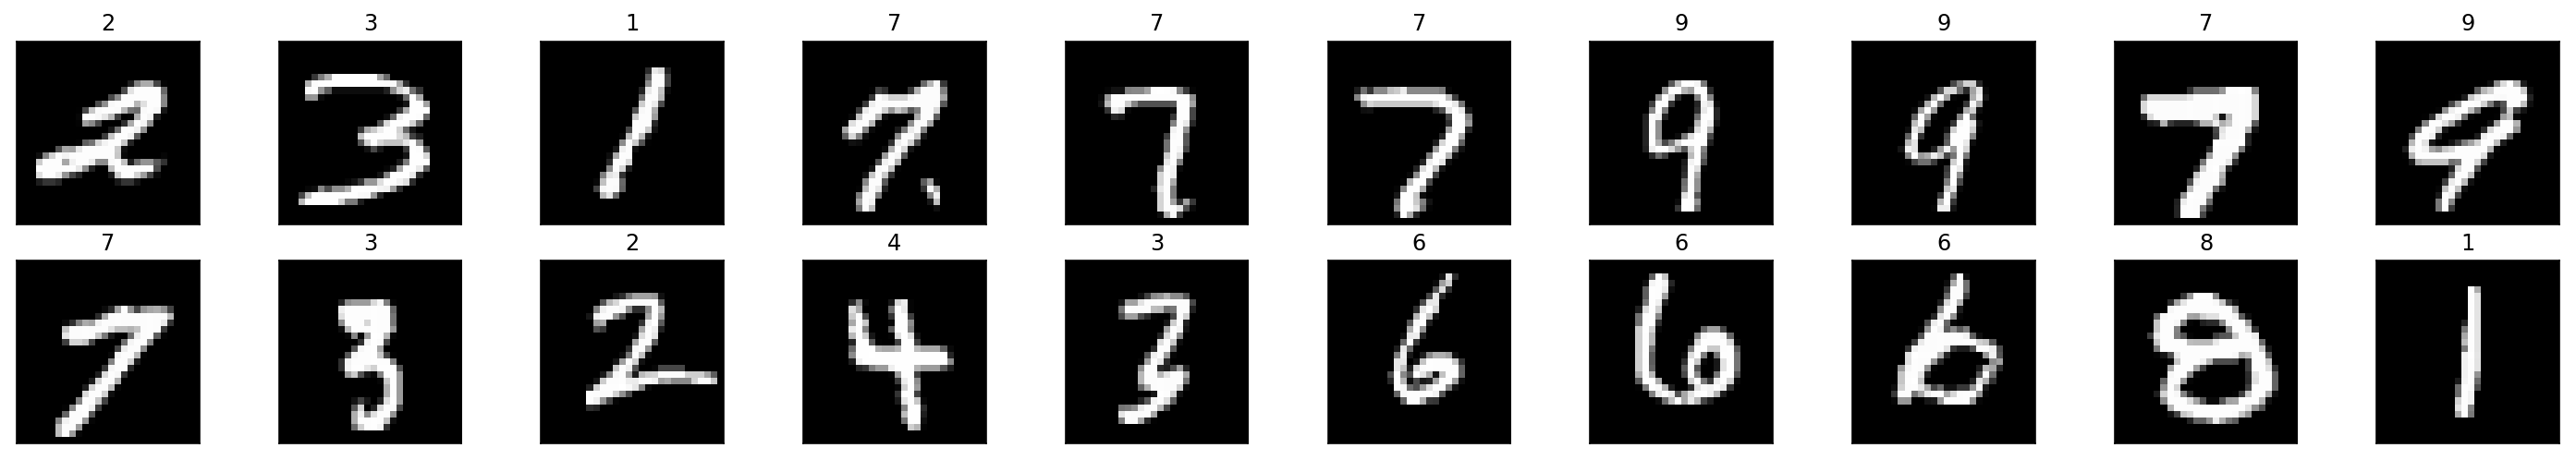

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

<h2>3. Network Architecture</h2> 

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2) # Dropout module with 0.2 drop probability

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)

        return x

<h2>4. Training the Network</h2> 


In [8]:
epochs = 10
models = []
teacher_loss = []
for i in range(num_teachers):
  model = Classifier()
  model.to(device)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.003)
  running_loss = 0
  for e in range(epochs):
    for images, labels in teacher_loaders[i]:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      log_ps = model(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  teacher_loss.append(running_loss)
  print("Loss {} : {}".format(i+1, running_loss))
  models.append(model)

Loss 1 : 88.9866623133421
Loss 2 : 102.19347202777863
Loss 3 : 100.42642152309418
Loss 4 : 86.30147374421358
Loss 5 : 101.6711578220129
Loss 6 : 101.40098462998867
Loss 7 : 90.95767955482006
Loss 8 : 96.19204260408878
Loss 9 : 98.9963705688715
Loss 10 : 85.76294160634279
Loss 11 : 81.23149297386408
Loss 12 : 95.72055695950985
Loss 13 : 116.46828791499138
Loss 14 : 92.02431380748749
Loss 15 : 107.46750974655151
Loss 16 : 101.79895505309105
Loss 17 : 94.10082475841045
Loss 18 : 90.73551316559315
Loss 19 : 84.54116740822792
Loss 20 : 102.09065379202366
Loss 21 : 93.1057552844286
Loss 22 : 113.48318609595299
Loss 23 : 92.76079089939594
Loss 24 : 106.39441072940826
Loss 25 : 105.82645189762115
Loss 26 : 96.00861708819866
Loss 27 : 105.82180790603161
Loss 28 : 99.27626237273216
Loss 29 : 105.92246228456497
Loss 30 : 113.01684793829918
Loss 31 : 88.32564021646976
Loss 32 : 103.47187772393227
Loss 33 : 76.71201438084245
Loss 34 : 97.8563586473465
Loss 35 : 101.5605603903532
Loss 36 : 94.027035

In [0]:
#Creating the public dataset
student_traindata = Subset(mnist_testset, list(range(9000)))
student_testdata = Subset(mnist_testset, list(range(9000, 10000)))

In [0]:
student_trainloader = torch.utils.data.DataLoader(student_traindata, batch_size=64, shuffle=True)
student_testloader = torch.utils.data.DataLoader(student_testdata, batch_size=64, shuffle=True)


In [0]:
def perdict(model, dataloader):
  outputs = torch.zeros(0, dtype=torch.long).to(device)
  model.to(device)
  model.eval()
  for image, labels in dataloader:
    image, labels = image.to(device), labels.to(device)  
    output = model(image)
    ps = torch.argmax(torch.exp(output), dim=1)
    outputs = torch.cat((outputs, ps))
  
  return outputs

In [0]:
epsilon = 0.1
preds = torch.zeros((len(models),9000), dtype=torch.long)
for i, model in enumerate(models):
  results = perdict(model, student_trainloader)
  preds[i] = results
  
labels = np.array([]).astype(int)
for image_preds in np.transpose(preds):  
  label_counts = np.bincount(image_preds, minlength = 10)
  beta = 1/ epsilon
  for i in range(len(label_counts)):
    label_counts[i] += np.random.laplace(0, beta, 1)
  new_label = np.argmax(label_counts)
  labels = np.append(labels, new_label)

In [0]:
student_labels = np.array(labels)
preds = preds.numpy()

In [0]:
def student_loader(student_trainloader, labels):
    for i, (data, _) in enumerate(iter(student_trainloader)):
        yield data, torch.from_numpy(labels[i*len(data): (i+1)*len(data)])

In [37]:
student_model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    trainloader = student_loader(student_trainloader, student_labels)
    for images, labels in trainloader:
        steps += 1
        optimizer.zero_grad()
        
        log_ps = student_model(images)
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in student_testloader:
                log_ps = student_model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(student_trainloader))
        test_losses.append(test_loss/len(student_testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(student_trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(student_testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(student_testloader)))

Epoch: 1/30..  Training Loss: 2.305..  Test Loss: 2.307..  Test Accuracy: 0.089
Epoch: 2/30..  Training Loss: 2.306..  Test Loss: 2.307..  Test Accuracy: 0.100
Epoch: 3/30..  Training Loss: 2.305..  Test Loss: 2.308..  Test Accuracy: 0.106
Epoch: 4/30..  Training Loss: 2.305..  Test Loss: 2.307..  Test Accuracy: 0.094
Epoch: 5/30..  Training Loss: 2.306..  Test Loss: 2.307..  Test Accuracy: 0.099
Epoch: 6/30..  Training Loss: 2.306..  Test Loss: 2.307..  Test Accuracy: 0.109
Epoch: 7/30..  Training Loss: 2.305..  Test Loss: 2.306..  Test Accuracy: 0.113
Epoch: 8/30..  Training Loss: 2.306..  Test Loss: 2.307..  Test Accuracy: 0.093
Epoch: 9/30..  Training Loss: 2.306..  Test Loss: 2.307..  Test Accuracy: 0.102
Epoch: 10/30..  Training Loss: 2.306..  Test Loss: 2.307..  Test Accuracy: 0.090
Epoch: 11/30..  Training Loss: 2.306..  Test Loss: 2.307..  Test Accuracy: 0.097
Epoch: 12/30..  Training Loss: 2.305..  Test Loss: 2.306..  Test Accuracy: 0.087
Epoch: 13/30..  Training Loss: 2.305.

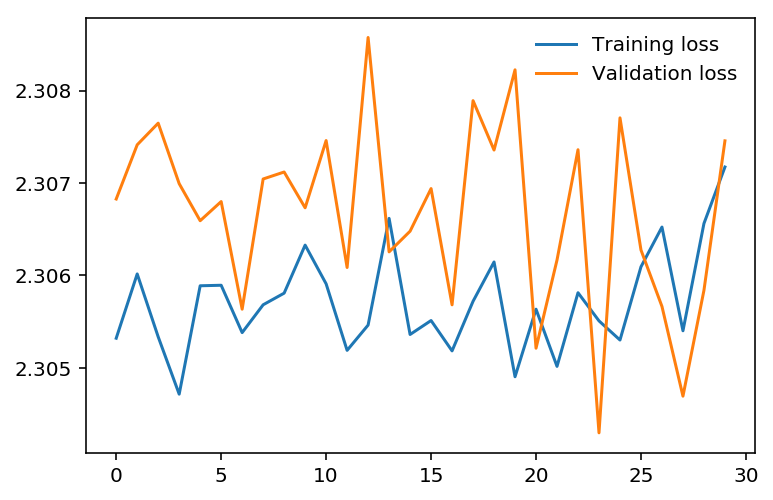

In [38]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

<h2>5. Installing and importing PySyft</h2> 

In [54]:
!pip install tf-encrypted

! URL="https://github.com/openmined/PySyft.git" && FOLDER="PySyft" && if [ ! -d $FOLDER ]; then git clone -b dev --single-branch $URL; else (cd $FOLDER && git pull $URL && cd ..); fi;

!cd PySyft; python setup.py install  > /dev/null

import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
!pip install --upgrade --force-reinstall lz4
!pip install --upgrade --force-reinstall websocket
!pip install --upgrade --force-reinstall websockets
!pip install --upgrade --force-reinstall zstd

     |████████████████████████████████| 1.4MB 33.7MB/s 
     |████████████████████████████████| 276kB 60.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'PySyft'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 26853 (delta 11), reused 13 (delta 6), pack-reused 26821
Receiving objects: 100% (26853/26853), 31.66 MiB | 5.66 MiB/s, done.
Resolving deltas: 100% (17528/17528), done.
zip_safe flag not set; analyzing archive contents...
zip_safe flag not set; analyzing archive contents...
__pycache__.zstd.cpython-36: module references __file__
     |████████████████████████████████| 389kB 33.6MB/s 
ERROR: syft 0.1.19a1 has requirement msgpack>=0.6.1, but you'll have msgpack 0

In [0]:
from syft.frameworks.torch.differential_privacy import pate

In [42]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=student_labels, noise_eps=epsilon, delta=1e-5, moments=20)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 371.5129254649703
Data Dependent Epsilon: 371.5129254650068
